In [73]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
import nibabel as nib
import numpy as np
import cv2
img=nib.load('BraTS20_Training_001_flair.nii')

In [75]:
data=img.get_fdata()
data_array=np.array(data)

In [76]:
print(data_array.shape)

(240, 240, 155)


In [77]:
image=data_array[:,:,77]

In [78]:
import numpy as np

def perlin_noise(width, height, scale=1000):
    # Generate a grid of random gradient vectors
    gradient_vectors = np.random.randn(width,height, 2)

    # Generate coordinates for each point in the grid
    y, x = np.mgrid[0:height, 0:width]
    x = x.astype(np.float32)
    y = y.astype(np.float32)

    # Rescale coordinates based on the scale parameter
    x /= scale
    y /= scale

    # Calculate indices of the grid cell containing each point
    xi = x.astype(int)
    yi = y.astype(int)

    # Determine the vectors from each corner of the grid cell to the point
    xf = x - xi
    yf = y - yi

    # Compute dot products between gradient vectors and offset vectors
    g00 = gradient_vectors[yi, xi]
    g01 = gradient_vectors[yi, xi + 1]
    g10 = gradient_vectors[yi + 1, xi]
    g11 = gradient_vectors[yi + 1, xi + 1]

    # Interpolate along x-axis
    wx = (3 - 2 * xf) * xf**2
    v00 = np.sum(g00 * np.stack([xf, yf], axis=2), axis=2)
    v01 = np.sum(g01 * np.stack([xf - 1, yf], axis=2), axis=2)
    v0 = v00 + wx * (v01 - v00)

    v10 = np.sum(g10 * np.stack([xf, yf - 1], axis=2), axis=2)
    v11 = np.sum(g11 * np.stack([xf - 1, yf - 1], axis=2), axis=2)
    v1 = v10 + wx * (v11 - v10)

    # Interpolate along y-axis
    wy = (3 - 2 * yf) * yf**2
    result = v0 + wy * (v1 - v0)
    result=((result+1)/2)*255
    return result.astype(np.uint8)

# Example usage:
width, height = 240, 240
scale = 25
noise = perlin_noise(width, height, scale)




In [79]:
import matplotlib.pyplot as plt

In [80]:
print(noise.shape)
print()

(240, 240)



In [81]:
print(np.max(image))

421.0


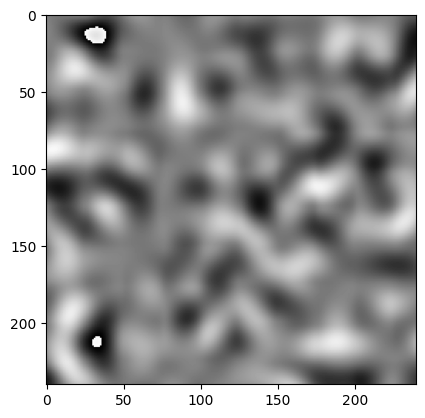

In [82]:
#Perlin_noise
plt.imshow(noise,cmap='gray')
plt.show()

In [83]:
def specific_gaussian(image):
# Define the region of interest (ROI)
# Example: selecting the top-left quarter of the image
    height, width = image.shape[:2]
    roi = (0, 0, int(width // 3.6), int(height // 3.6))
    mask = np.zeros_like(image[:, :])
    mask[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]] = 255
    blurred_roi = cv2.GaussianBlur(image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]], (3, 3), 0)

    image_blurred = np.copy(image)
    image_blurred[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]] = blurred_roi
    return image_blurred

In [84]:
def perlinification(data_array,rate=1,Gaussian_bool=False):
    new_data_array=np.zeros(data_array.shape)
    xmax,ymax,time=data_array.shape
    for t in range(time):
        new_image=np.copy(data_array[:,:,t])
        if t==5:
            plt.imshow(new_image)
            plt.show()
        if t%rate==0:
            perlin=perlin_noise(int(xmax/3.6),int(ymax/3.3),50)
            
        new_image[0:int(xmax/3.3),0:int(ymax/3.6)]=new_image[0:int(xmax/3.3),0:int(ymax/3.6)]+perlin
        if Gaussian_bool:
            new_image=specific_gaussian(new_image)
        new_data_array[:,:,t]=new_image
    return new_data_array
    

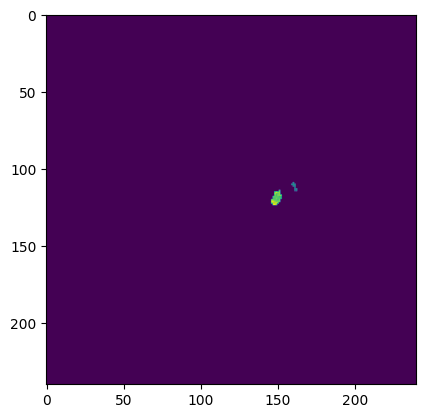

In [92]:
perlin_data=perlinification(data_array,rate=3)


In [86]:
# Determine the dimensions of the images
def video_maker(name,data_array):
    height, width,time = data_array.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 24  # Frames per second
    out = cv2.VideoWriter(name+".mp4", fourcc, fps, (width, height),isColor=False)

# Write each image to the video file
    for t in range(time):
        wiw=np.uint8(data_array[:,:,t])
        out.write(wiw)
    out.release()
    print("Video created successfully!")

In [87]:
video_maker("perlin_video_modified",perlin_data)

Video created successfully!


In [93]:
import nibabel as nib
import numpy as np

# Assuming you have modified data_array extensively

# Create a new NIfTI image from the modified data array
new_img = nib.Nifti1Image(perlin_data, img.affine)

# Save the new NIfTI image to a file
nib.save(new_img, 'perlin_data.nii')